# Project: Ubiquitous Computing Project 2

Date: 05.2021

Authors: 
 * Rayan Armani [rarmani@ethz.ch]
 * Massimo Albarello [malbarello@ethz.ch]

## 0. Importing data and necessary libraries


In [2]:
import pickle as pickle 
import numpy as np
from scipy import signal, stats
import matplotlib.pyplot as plt
import pandas as pd
import pprint
# from ecgdetectors import Detectors

with open("ex2_recordings/participant_01.pkl", "rb") as f:
    particiapnt_01_data = pickle.load(f)


## 1. Feature extraction and data analysis

### 1.1 ECG

#### a) Plotting the PSD
The Lead I ECG signal is the difference between the sensor measurements of the left and right arms. To find its Power Spectral Density we use Welch's method such as in Abadi et al.  

References:
* [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)
* [Mojtaba Khomami Abadi, Ramanathan Subramanian, Seyed Mostafa Kia, Paolo Avesani, Ioannis Patras, and Nicu Sebe. Decaf: Meg-based multimodal database for decoding affective physiological responses. *IEEE Transactions on Affective Computing*, 6(3):209–222, 2015 ](https://stefan.winkler.site/Publications/tac2015.pdf)

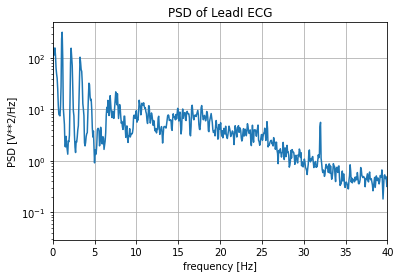

In [108]:
# Extract sampling frequency of ECG
ECG_freq = particiapnt_01_data["FS_ECG"]

# Extract Lead I ECG (left_hand - right hand) signal of the first participant watching clip 1
raw_ECG_p1 = np.array(particiapnt_01_data["recordings"][1]["ECG"])

lead1_ecg_p1= np.array(raw_ECG_p1[:,1]-raw_ECG_p1[:,2])

# Parameters for calculating the PSD 
# From [1] in exercise handout: Welch method using window length of 15xsr overlap 10xsr where sr denotes sampling rate
f, Pxx_den = signal.welch(x=lead1_ecg_p1, fs= ECG_freq, nperseg = 15*ECG_freq, noverlap= 10*ECG_freq, scaling='density', average='mean')

plt.semilogy(f, Pxx_den)
plt.xlim(0,40)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD of LeadI ECG')
plt.grid(True)
plt.show()


#### b) Signal filtering

The raw Lead I ECG is inherently noisy, as shown by the presence of high frequency components as revealed in the PSD. Features of interest in an ECG however, are in the lower frequency ranges. From the PSD plot, we can infer that the signal's most significant components lie in the [0-20Hz] range. As such we can design a low pass filter to remove noise components with frequencies above 20Hz, using scipy's implementation of a Butterworth filter. When we plot the results from a simple low pass filter, we notice the baseline is not stable. To reduce the effect of a wandering baseline, we add a high pass filter at 2Hz. We can combine both filters in a bandapss filter over [4-20Hz] 
Notes: **most papers I reaad mentioned filtering with a cutoff at 20Hz ex: https://www.hindawi.com/journals/cmmm/2015/453214/

References: 
* [scipy.signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)
* [scipy repository on github](https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass)


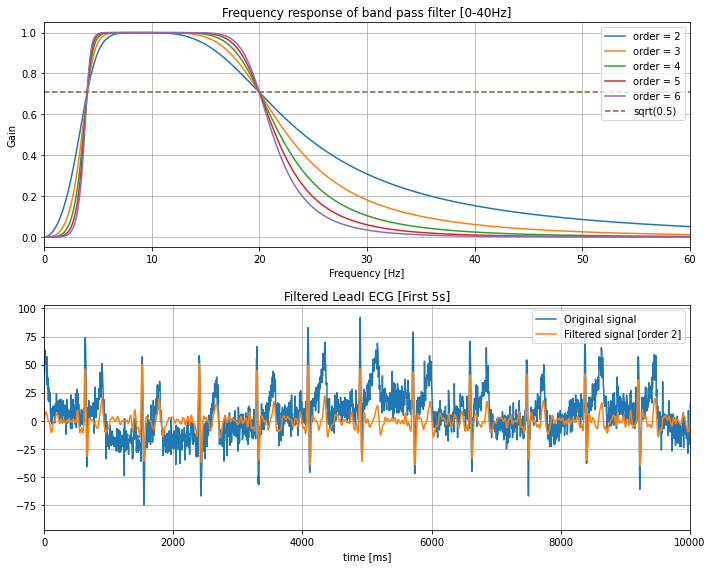

In [109]:

# Low pass filter definition functions
def butter_bandpass(lowcut, highcut,fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order,[low,high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = signal.filtfilt(b, a, data)
    return y
# Low pass filter implementation
# Parameters
lowcut = 4 #[Hz]
highcut = 20
fs = ECG_freq

# Plot the frequency response for a few different orders.
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10, 8), sharex=False)

for order in [2,3,4,5,6]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" %order)

ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_xlim(0,60)
ax[0].set_ylabel('Gain')
ax[0].grid(True)
ax[0].set_title('Frequency response of band pass filter [0-40Hz]') 
ax[0].legend(loc='upper right')

# Choose filter order
order = 2
# Apply the low pass filer to the lead I ECG filter
filtered_lead1_ecg_p1 = butter_bandpass_filter(lead1_ecg_p1,lowcut, highcut, fs, order)

# Get time 
t = np.array(raw_ECG_p1[:,0]) - raw_ECG_p1[0,0] #[ms]

# Plot the first 5s of the filtered signal in time domain
ax[1].plot(t,lead1_ecg_p1, label='Original signal')
ax[1].plot(t,filtered_lead1_ecg_p1, label='Filtered signal [order %d]' %order)
ax[1].set_xlabel('time [ms]')
ax[1].set_xlim(0,10000)
ax[1].grid(True)
ax[1].set_title('Filtered LeadI ECG [First 5s]') 
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


#### c) Artifact detection 

We are looking for the percentage of recorded ECG data that contains artifacts over the complete dataset (last 50 s for each clip). This can be computed by taking the ratio between the sum of the flagged intervals and the accumulated time of the ECG recordings. 
 

References: 

C:\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


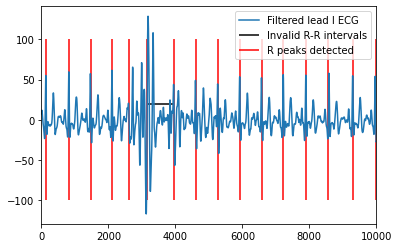

C:\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
Percentage of ECG data having defects: 1.274232%


In [4]:
# Utility functions for artifact detection algorithm
def get_RRI(filtered_ecg_signal, fs):
    '''
    Returns an array containing the RR peak intervals for a signal, in ms. 
    '''
    # Compute the derivative og the filtered signal
    diff = np.diff(filtered_ecg_signal) 

    # Compute the square of the derivative to evidence the peaks in the signal
    squared = diff*diff

    # Use scipy find RR peaks (hand tuned)
    # peaks, _ = signal.find_peaks(squared, height= 50, threshold= None, distance=150, prominence= 100)
    peaks, _ = signal.find_peaks(squared, height= 20, threshold= None, distance=120, prominence= 10)

    RRI = np.diff(peaks)
    RRI_ms = RRI*1000/fs
    
    return RRI_ms, peaks

def get_CBD(RRI):
    '''
    Return the Criterion Beat Difference given an array of RR peaks intervals. Based on the work of Hovsepian et al. 
    '''
    Q1 = np.nanpercentile(RRI, 25)
    Q2 = np.nanpercentile(RRI, 50)
    Q3 = np.nanpercentile(RRI, 75)

    QD = (Q3-Q1)/2.0 # Quartile Deviation
    MAD = (Q2-2.9*QD)/3.0
    MED = 3.32*QD

    CBD =(MAD+MED)/2.0
    return CBD

def detect_artifacts(ecg_signal, fs):
    '''
    Detects artifacts in ECG signal. Input needs to be filtered ecg
    '''
    has_artifacts = False
    last_valid_RRI = 0

    valid_RRI_indices = np.ones((1,len(RRI))).reshape(-1,1)
    for i in range(1,len(RRI)-1):
        if RRI[i-1] >= 300 and RRI[i-1]<=2000:
            if abs(RRI[i]-RRI[i-1])<=CBD:
                valid_RRI_indices[i]=1
            else: 
                valid_RRI_indices[i]=0
        else:
            if abs(RRI[i]-last_valid_RRI)<=CBD:
                valid_RRI_indices[i]=1
            else:
                if abs(RRI[i]-RRI[i-1])<=CBD and abs(RRI[i]-RRI[i+1])<=CBD:
                    valid_RRI_indices[i]=1
                else:
                    valid_RRI_indices[i]=0
                    

    # Count artifacts
    n_artifacts = len(RRI)-np.sum(valid_RRI_indices)
    if n_artifacts > 0:
        has_artifacts = True
    return has_artifacts, valid_RRI_indices

# Variables for percentage calculation
total_time = 0
total_artifact_time = 0

# load ECG data
for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of ECG
        fs = participant_data["FS_ECG"]

        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract ECG for each clip 
        for clip in clip_ids:
            raw_ECG= np.array(participant_data["recordings"][clip]["ECG"])
            # Get lead1 ECG signal
            lead1_ecg= np.array(raw_ECG[:,1]-raw_ECG[:,2])
            t = np.array(raw_ECG[:,0]) - raw_ECG[0,0] #[ms]

            # Filter ECG signal
            filtered_lead1_ecg = butter_bandpass_filter(lead1_ecg,lowcut, highcut, fs, order)
            
            # Truncate the signal to look at only the last 50s of the signal
            filtered_lead1_ecg_50s= filtered_lead1_ecg[-(50*fs):] 
            t = t[-(50*fs):]
            t = t-t[0]

            # Add the 50s to the total time
            total_time += 50*1000.0 #[ms]

            # Get RR peaks intervals
            RRI, peaks = get_RRI(filtered_lead1_ecg_50s, fs)

            # Get Criterion beat interval for artifact detection
            CBD = get_CBD(RRI)

            # Check for artifacts
            artifact, idx = detect_artifacts(RRI, CBD)

            if artifact == True:
                # Find the total time of flagged intervals
                artifact_indices = np.where(idx==0)[0]
                artifacts_time = np.sum(RRI[artifact_indices])

                # Add to the general flagged time counter
                total_artifact_time += artifacts_time

                # plot the section with artifact(s) for a select clip
                if i==6 and clip==13:
                    # other candidates: i = 5 , clip = 26
                    plt.plot(t,filtered_lead1_ecg_50s, label='Filtered lead I ECG')
                    for j in artifact_indices:
                        plt.hlines(20, peaks[j]*1000/fs, peaks[j+1]*1000/fs,color='black', label="Invalid R-R intervals")
                    legend = False
                    for k in peaks:
                        if not(legend):
                            plt.vlines(k*1000/fs, -100, 100, color='r', label='R peaks detected')
                            legend = True
                        else: 
                            plt.vlines(k*1000/fs, -100, 100, color='r')
                    plt.legend()
                    plt.xlim(0, 10000)
                    plt.show()
                
percentage = 100*(total_artifact_time/total_time)
print("Percentage of ECG data having defects: {:2f}%".format(percentage))


#### d) Feature extraction

References: 

In [242]:
#### Utils ####

def statisticalMeasurements(values, signal, item):
    mean = np.mean(values)
    stats_dictionary[i][clip][signal][item].update({"mean" : mean})
    stdev = np.std(values)
    stats_dictionary[i][clip][signal][item].update({"stdev" : stdev})
    skewness = stats.skew(values)
    stats_dictionary[i][clip][signal][item].update({"skewness" : skewness})
    kurtosis = stats.kurtosis(values)
    stats_dictionary[i][clip][signal][item].update({"kurtosis" : kurtosis})
    # print("\nThe {} values have: \nmean: {:.2f}\nstandard deviation: {:.2f}\nskewness: {:.2f}\nkurtosis: {:.2f}".format(item, mean, stdev, skewness, kurtosis))

    tot = len(values)
    count = 0
    for value in values:
        if value < mean - stdev or value > mean + stdev:
            count += 1
    # print('The percentage of times the {} is more than a standard deviation away from the mean is: {:.2f}%'.format(item, count/tot))



stats_dictionary = {}

for i in range(1, 36):
    if i < 9:
        pn = "0"+str(i)
    else: 
        pn = str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of ECG
        fs = participant_data["FS_ECG"]

        # Clips
        clip_ids=participant_data["recordings"].keys()

        stats_dictionary.update({i : {}})
        # Extract ECG for each clip 
        for clip in clip_ids:
            stats_dictionary[i].update({clip : {
                "ECG" : {
                    "interBeatInter" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "heartRateVar" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "heartRate" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    }
                }
            }})
            raw_ECG= np.array(participant_data["recordings"][clip]["ECG"])
            # Get lead1 ECG signal
            lead1_ecg = np.array(raw_ECG[:,1]-raw_ECG[:,2])
            t = np.array(raw_ECG[:,0]) - raw_ECG[0,0] #[ms]

            # Filter ECG signal
            filtered_lead1_ecg = butter_bandpass_filter(lead1_ecg,lowcut, highcut, fs, order)
            
            # Truncate the signal to look at only the last 50s of the signal
            filtered_lead1_ecg_50s = filtered_lead1_ecg[-(50*fs):] 
            t = t[-(50*fs):]
            t = t - t[0]

            peaks, _ = signal.find_peaks(filtered_lead1_ecg_50s, distance=150)
            # plt.plot(filtered_lead1_ecg_50s)
            # for i in peaks:
            #     plt.axvline(i, ymin=0.6, ymax=0.8, color='r')
            # # plt.plot(peaks, samples[peaks], "x")
            # plt.show()

            # print('\nCLIP {} of participant {}'.format(clip, i))
            interBeatInter = np.diff(peaks/fs)     # time difference in ms between adjacent heart beats
            # print(interBeatInter)
            statisticalMeasurements(interBeatInter, 'ECG', 'interBeatInter')

            heartRateVar = np.diff(interBeatInter)  # time difference in ms between two adjacent inter beat intervals
            # print(heartRateVar)
            statisticalMeasurements(heartRateVar, 'ECG', 'heartRateVar')

            # using moving average to calculate "local" heart rate
            window_size = 5     #averaging over 5 inter beat inetervals
            numbers_series = pd.Series(1/interBeatInter)
            windows = numbers_series.rolling(window_size)
            moving_averages = windows.mean()
            moving_averages_list = moving_averages.tolist()
            heartRate = moving_averages_list[window_size - 1:]
            # print(heartRate)
            statisticalMeasurements(heartRate, 'ECG', 'heartRate')

pprint.pprint(stats_dictionary)


7787,
                                 'mean': 1.361065539121838,
                                 'skewness': -0.10605878108244612,
                                 'stdev': 0.10057319250426248},
                   'heartRateVar': {'kurtosis': 4.068014254086642,
                                    'mean': -0.0011245265151515152,
                                    'skewness': 1.3472477810256098,
                                    'stdev': 0.06810699878856132},
                   'interBeatInter': {'kurtosis': 0.9982823102947656,
                                      'mean': 0.7398554104477612,
                                      'skewness': 1.0399196325933253,
                                      'stdev': 0.07840742939003642}}},
      13: {'ECG': {'heartRate': {'kurtosis': -0.5191985974059303,
                                 'mean': 1.501397750042788,
                                 'skewness': -0.5078374009116252,
                                 'stdev': 0.07060349355395903},


#### e) Extraction of additional features 

References: 

### 1.2 EMO
Text explanations can go here or in between python cells in the following parts

In [39]:
for i in range(1, 36):
    if i < 9:
        pn = "0"+str(i)
    else: 
        pn = str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Clips
        clip_ids=participant_data["recordings"].keys()

        # Extract EMO for each clip 
        for clip in clip_ids:
            stats_dictionary[i].update({clip : {
                "EMO" : {
                    "verDefUpLip" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "verDefLowLip" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "horDefLeftLipCorner" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "verDefLeftLipCorner" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "horDefRightLipCorner" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "verDefRightLipCorner" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "defRightEyebrow" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "defLeftEyebrow" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "defRightCheek" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "defLeftCheek" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "defRightLid" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                    "defLeftLid" : {
                        "mean" : 0,
                        "stdev" : 0,
                        "skewness" : 0,
                        "kurtosis" : 0
                    },
                }
            }})
            raw_EMO = np.array(participant_data["recordings"][clip]["EMO"])     
            statisticalMeasurements(raw_EMO[:, 1], 'EMO', 'verDefUpLip')
            statisticalMeasurements(raw_EMO[:, 2], 'EMO', 'verDefLowLip')
            statisticalMeasurements(raw_EMO[:, 3], 'EMO', 'horDefLeftLipCorner')
            statisticalMeasurements(raw_EMO[:, 4], 'EMO', 'verDefLeftLipCorner')
            statisticalMeasurements(raw_EMO[:, 5], 'EMO', 'horDefRightLipCorner')
            statisticalMeasurements(raw_EMO[:, 6], 'EMO', 'verDefRightLipCorner')
            statisticalMeasurements(raw_EMO[:, 7], 'EMO',  'defRightEyebrow')
            statisticalMeasurements(raw_EMO[:, 8], 'EMO', 'defLeftEyebrow')
            statisticalMeasurements(raw_EMO[:, 9], 'EMO', 'defRightCheek')
            statisticalMeasurements(raw_EMO[:, 10], 'EMO', 'defLeftCheek')
            statisticalMeasurements(raw_EMO[:, 11], 'EMO', 'defRightLid')
            statisticalMeasurements(raw_EMO[:, 12], 'EMO', 'defLeftLid')

pprint.pprint(stats_dictionary)





                                   'mean': -0.24418334957560517,
                                    'skewness': -1.917731509712535,
                                    'stdev': 0.8794628491110089},
                   'defLeftEyebrow': {'kurtosis': 0.06412090601716747,
                                      'mean': -0.9360202008802263,
                                      'skewness': 0.23444976542917847,
                                      'stdev': 0.22699205278781256},
                   'defLeftLid': {'kurtosis': 1.7834526065786331,
                                  'mean': -1.0958270594152781,
                                  'skewness': 1.3708216997234548,
                                  'stdev': 0.3123049688804714},
                   'defRightCheek': {'kurtosis': 3.3136872649723506,
                                     'mean': 0.6459278689091481,
                                     'skewness': 1.166451948186674,
                                     'stdev': 0.43700115415606

### 1.3 EDA
Text explanations can go here or in between python cells in the following parts

In [251]:
for i in range(1, 2):
    if i < 9:
        pn = "0"+str(i)
    else: 
        pn = str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Clips
        clip_ids=participant_data["recordings"].keys()

        # Extract sampling frequency of ECG
        fs = participant_data["FS_GSR"]
        # print(fs)

        # Extract EMO for each clip 
        clip = 1
        # for clip in clip_ids:
            
        raw_EDA = np.array(participant_data["recordings"][clip]["GSR"])   
        # print(len(raw_EDA))
        # Truncate the signal to look at only the last 50s of the skin resistance signal
        raw_EDA_50s = raw_EDA[-(50*fs):]
        # print(raw_EDA_50s[:,1])
        sig_EDA_50s = raw_EDA_50s[:,1]
        timestamps = raw_EDA_50s[:,0]
        dt = np.mean(np.diff(timestamps))   # time difference between adjacent samples

        # mean skin resistance
        mean = np.mean(sig_EDA_50s)
        # print(mean)

        # mean of first derivatives of skin resistance
        firstDer = np.gradient(sig_EDA_50s, dt)
        meanFirstDer = np.mean(firstDer)
        # print(meanFirstDer)

        # mean of absolute values of first derivatives of skin resistance
        meanAbsFirstDer = np.mean(np.abs(firstDer))
        # print(meanAbsFirstDer)

        # mean first derivative for negative values only (mean of the negative values of the first derivaive???)
        negValFirstDer = []
        count = 0
        for val in firstDer:
            if val < 0:
                count += 1
                negValFirstDer.append(val)
        # print(negValFirstDer)
        meanNegValFirstDer = np.mean(negValFirstDer)
        # print(meanNegValFirstDer)

        # percentage of time with negative first derivative
        percNegVal = count/len(firstDer)
        # print(percNegVal)

        # standard deviation of skin resistance
        stdev = np.std(sig_EDA_50s)
        # print(stdev)

        # number of local minima in the skin conductance signal
        conductance = 1 / sig_EDA_50s
        # plt.plot(conductance)
        minimaCond = signal.find_peaks(-conductance, distance=500)
        minimaCond = minimaCond[0][:-3]
        minimaCond = np.delete(minimaCond, [-4, -3])
        # for minimum in minimaCond:
        #     plt.axvline(minimum, color='r')
        # plt.axvline(3300, color='r')
        # plt.show()
        numLocMin = len(minimaCond) + 1
        # print(numLocMin)

        # average rising time of GSR signal (time from 10% to 90% of the increase)
        minima = signal.find_peaks(-sig_EDA_50s, distance=650)
        minima = minima[0][:-3]
        # considering only significant increases
        minima = np.delete(minima, [3, 4])
        # print(minima)
        # plt.plot(sig_EDA_50s)
        maxima = signal.find_peaks(sig_EDA_50s, distance=600)
        maxima = maxima[0][:-3]
        maxima = np.delete(maxima, [3, 4])
        # print(maxima)
        # for maximum in maxima:
        #     plt.axvline(maximum, color='g')
        # for minimum in minima:
        #     plt.axvline(minimum, color='r')
        rises = sig_EDA_50s[maxima] - sig_EDA_50s[minima]
        startRiseHeights = np.add(sig_EDA_50s[minima], 0.1*rises)
        endRiseHeights = np.add(sig_EDA_50s[minima], 0.9*rises)
        indexPairs = []
        i = 0
        for j in minima:
            while j < 6400 and sig_EDA_50s[j] < startRiseHeights[i]:
                j += 1
            indexPairs.append([j,])
            while j < 6400 and sig_EDA_50s[j] < endRiseHeights[i]:
                j += 1
            indexPairs[i].append(j)
            i += 1
        # print(indexPairs)
        risetimes = []
        for indexes in indexPairs:
            # plt.axvline(indexes[0], color='r')
            # plt.axvline(indexes[1], color='g')
            risetimes.append(indexes[1] - indexes[0])
        # print(risetimes)
        avgRiseTime = (np.mean(risetimes))/fs
        # print(avgRiseTime)
        # plt.show()

        # TBD: power density estimates !!!

        # standard deviation of skin conductance
        stdev = np.std(conductance)
        # print(stdev)

        # mean of first derivatives of skin conductance
        firstDerConduct = np.gradient(conductance, dt)
        meanFirstDerConduct = np.mean(firstDerConduct)
        # print(meanFirstDerConduct)

        # mean of absolute values of first derivatives of skin conductance
        meanAbsFirstDerConduct = np.mean(np.abs(firstDerConduct))
        # print(meanAbsFirstDerConduct)

        # mean of absolute values of first derivatives of skin conductance
        secDerConduct = np.gradient(firstDerConduct, dt)
        meanAbsFirstDerConduct = np.mean(np.abs(secDerConduct))
        # print(meanAbsFirstDerConduct)

        # number of local minima in the skin resistance signal
        minima = signal.find_peaks(-sig_EDA_50s, distance=650)
        minima = minima[0]
        minima = np.delete(minima, [-3, -2])
        # plt.plot(sig_EDA_50s)
        # for minimum in minima:
        #     plt.axvline(minimum, color='r')
        # plt.axvline(4650, color='r')
        # plt.show()
        numLocMin = len(minima) + 1
        # print(numLocMin)

        # TBD: log power density estimates !!!


In [181]:
### 1.4 Valence and arousal

## 2. Classification
Text explanations can go here or in between python cells in the following parts